# Load Dependencies


In [1]:
%load_ext autoreload
%autoreload 2

import os
import matplotlib.pyplot as plt
import torch
import mira
import pandas as pd

import pyciemss
from pyciemss.utils import get_tspan

from pyciemss.PetriNetODE.interfaces import load_petri_model, setup_petri_model, reset_petri_model, sample_petri, calibrate_petri, intervene_petri_model, optimize_petri
from pyciemss.PetriNetODE.base import MiraPetriNetODESystem, ScaledBetaNoisePetriNetODESystem
from pyciemss.PetriNetODE.events import Event, StartEvent, LoggingEvent, ObservationEvent, StaticParameterInterventionEvent
from pyciemss.PetriNetODE.models import IDART_obs, Case_obs

from pyciemss.Ensemble.base import EnsembleSystem
from pyciemss.Ensemble.interfaces import setup_model, reset_model, intervene, sample, calibrate, optimize

import mira

import warnings
warnings.filterwarnings('ignore')


# Plotting Utilities


In [63]:

def setup_ax(ax=None, xlabel='Time (days)', ylabel='Infectious (US population)'):

    if not ax:
        fig = plt.figure(facecolor='w', figsize=(9, 9))
        ax = fig.add_subplot(111, axisbelow=True)
    ax.set_yscale('log')
    ax.set_xlabel(xlabel) #I think labeling this 'Time (days)' is a bit more clear, Time/days => time per days
    ax.set_ylabel(ylabel) #This is fine but epi-people often use "per 100,000." This is nitpicky also, but try to use "infectious" rather than infected.
    return ax

def plot_predictive(prediction, vnames, tspan, tmin=None, ax=None, alpha=0.2, color="black", **kwargs):
    
    I_low = torch.quantile(prediction[vnames], 0.05, dim=0).detach().numpy()
    I_up = torch.quantile(prediction[vnames], 0.95, dim=0).detach().numpy()

    if tmin:
        indeces = tspan >= tmin
    else:
        indeces = torch.ones_like(tspan).bool()

    if not ax:
        fig = plt.figure(facecolor='w')
        ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
    
    ax.fill_between(tspan[indeces], I_low[indeces], I_up[indeces], alpha=alpha, color=color, **kwargs)

    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)
    ax.set_yscale('log')

    return ax

def plot_trajectory(data, vnames, tspan,  ax=None, color='black', alpha=0.5, lw=0, marker='.', label=None, ):
    # Plot the data on three separate curves for S(t), I(t) and R(t)

    if not ax:
        fig = plt.figure(facecolor='w')
        ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
    if type(data[vnames]) is torch.Tensor:
        data[vnames] = data[vnames].squeeze().detach().numpy()
    ax.plot(tspan, data[vnames], color, alpha=alpha, lw=lw, marker=marker, label=label)
    ax.set_yscale('log')

    return ax

def plot_intervention_line(t, ax=None):
    if not ax:
        fig = plt.figure(facecolor='w')
        ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)

    ylim = ax.get_ylim()

    ax.vlines(t, min(ylim), max(ylim), color="grey", ls='-')

    return ax

# Setup Parameters


In [3]:
num_days = 120
full_tspan = get_tspan(1, num_days, num_days*10) # 10 points per day to accomodate the solver

# Number of samples for forecasting & plotting
num_samples = 100

# Total population, N (approximate population of India)
N = 1.4*10**9
US_population = 331893745  # Based on https://datacommons.org/place/country/USA?utm_medium=explore&mprop=count&popt=Person&hl=en

In [4]:
# # Initial number of infected and recovered individuals, I0 and R0.
# V0, I0, Iv0, R0 = 0., 81.0, 0., 0. #may want to revisit this choice, consider setting I0 to 1 (there will not be zero recovered people when there are 81 infectious people)
# # Everyone else, S0, is susceptible to infection initially.
# S0 = N - I0 - Iv0 - V0 - R0

# 18 - 24 year olds
# plot_I_obs = dict(I_obs=torch.tensor([81.47, 84.3, 86.44, 89.66, 93.32, 94.1, 96.31])) #these numbers make no sense, why not use whole numbers?
# I_obs = [(float(i+1), dict(I_obs=obs/N)) for i, obs in enumerate([81.47, 84.3, 86.44, 89.66, 93.32, 94.1, 96.31])]

# observed_tspan = get_tspan(1, len(I_obs), len(I_obs)) #also bad

# # named_initial_state = {
# #     "S": torch.as_tensor(S0),
# #     "V": torch.as_tensor(V0),
# #     "I": torch.as_tensor(I0),
# #     "I_v": torch.as_tensor(Iv0),
# #     "R": torch.as_tensor(R0),
# # }

# # named_final_state = {
# #     "S": torch.as_tensor(S0),
# #     "V": torch.as_tensor(V0),
# #     "I": I_obs[-1],
# #     "I_v": torch.as_tensor(Iv0),
# #     "R": torch.as_tensor(R0),
# # }
# display(plot_I_obs)
# display(I_obs)

# Probabilistic Forecasting - Ignoring Historical Data

import json #this doesn't work??
  
petri_net_ode_model = load_petri_model('../../test/models/SVIIvR.json')
petri_net_ode_model

from pyciemss.PetriNetODE.models import MIRA_SVIIvR
petri_net_ode_model = MIRA_SVIIvR.from_mira('../../test/models/SVIIvR.json')

from pyciemss.PetriNetODE.models import MIRA_I_obs_with_scaled_Gaussian_noise
petri_net_ode_model = MIRA_I_obs_with_scaled_Gaussian_noise.from_mira('../../test/models/SVIIvR.json')
petri_net_ode_model.total_population = N
petri_net_ode_model.data_reliability = 4.0
petri_net_ode_model

from mira.examples.chime import sviivr
dir(sviivr)

import json
with open('../../test/models/chime.sviivr.json', 'w') as out:
    out.write(sviivr.json())
    


from pyciemss.PetriNetODE.models import MIRA_I_obs_with_scaled_Gaussian_noise
petri_net_ode_model = MIRA_I_obs_with_scaled_Gaussian_noise.from_mira('../../test/models/chime.sviivr.json')
petri_net_ode_model.total_population = N
petri_net_ode_model.data_reliability = 4.0
petri_net_ode_model

## Load the model

In [4]:
MIRA_PATH = "../../test/models/april_ensemble_demo/"

In [5]:
# model_json = '../../test/models/SVIIvR_mira.json'

filename1 = "BIOMD0000000955_template_model.json"
filename1 = os.path.join(MIRA_PATH, filename1)
# model1 = load_petri_model(filename1, add_uncertainty=True)

# model1 = IDART_obs.from_mira(filename1)
model1 = Case_obs.from_mira(filename1)

model1.total_population = N
model1.data_reliability = 4.0 # for Gaussian models
model1.pseudocounts = 5.0 # for Beta models

# TODO: put this into the interfaces
start_state1 = {k[0]: v.data['initial_value'] for k, v in model1.G.variables.items()}
start_state1
start_state2 = dict(Susceptible=(US_population-(230-10-10-13-2))/US_population, 
                    Infected=230/US_population, 
                    Diagnosed=10/US_population, 
                    Ailing=10/US_population, 
                    Recognized=13/US_population, 
                    Healed=0, 
                    Threatened=0, 
                    Extinct=2/US_population)
start_state1, start_state2

({'Susceptible': 0.9999963,
  'Infected': 3.33333333e-06,
  'Diagnosed': 3.33333333e-07,
  'Ailing': 1.66666666e-08,
  'Recognized': 3.33333333e-08,
  'Healed': 0.0,
  'Threatened': 0.0,
  'Extinct': 0.0},
 {'Susceptible': 0.9999994124625639,
  'Infected': 6.929928733667457e-07,
  'Diagnosed': 3.013012492898894e-08,
  'Ailing': 3.013012492898894e-08,
  'Recognized': 3.916916240768563e-08,
  'Healed': 0,
  'Threatened': 0,
  'Extinct': 6.026024985797789e-09})

### Consolidate variables needed for IDART observations

In [7]:
IDART_vars = ["Infected", "Diagnosed", "Ailing", "Recognized", "Threatened"]

In [8]:
### Available Data -to- state variable map
# Case Census = Diagnosed + Recognized
# Hospital Census = Threatened ### Assumed that seriously ill means hospitalized
# Cumulative Death = Extinct

In [6]:
# DRTE_vars = ["Diagnosed", "Recognized", "Threatened", "Extinct"]
Case_vars = ["Diagnosed", "Recognized"]
Hosp_var = "Threatened"
Death_var = "Extinct"

from pyciemss.PetriNetODE.base import SVIIvRPetriNetODESystem
petri_net_ode_model = SVIIvRPetriNetODESystem.from_mira('../../test/models/SVIIvR.json')

petri_net_model = load_petri_model(model_json)
petri_net_model

## Initialize

In [7]:
initialized_model1 = setup_petri_model(model1, start_time=0.0, start_state=start_state2)

## Q: "What likely future outcomes does our model imply?"

### Sample a single trajectory from the prior distribution

In [40]:
# single_prior = sample_petri(initialized_model1, timepoints=full_tspan, num_samples=1)
# single_prior['IDART_obs'] = sum([single_prior[f'{v}_sol'] for v in IDART_vars])
# single_prior['IDART_obs']

In [8]:
single_prior = sample_petri(initialized_model1, timepoints=full_tspan, num_samples=1)
single_prior['Case_obs'] = sum([single_prior[f'{v}_sol'] for v in Case_vars])
single_prior['Case_obs']

tensor([[2.1211e-07, 2.2933e-07, 2.4715e-07,  ..., 4.2481e-02, 4.2309e-02,
         4.2138e-02]])

### Sample 100 trajectories from the prior distribution

In [12]:
# prior_prediction = sample(initialized_model1, timepoints=full_tspan, num_samples=100)
# prior_prediction['IDART_obs'] = sum([prior_prediction[f'{v}_sol'] for v in IDART_vars])

In [9]:
prior_prediction = sample(initialized_model1, timepoints=full_tspan, num_samples=100)
prior_prediction['Case_obs'] = sum([prior_prediction[f'{v}_sol'] for v in Case_vars])

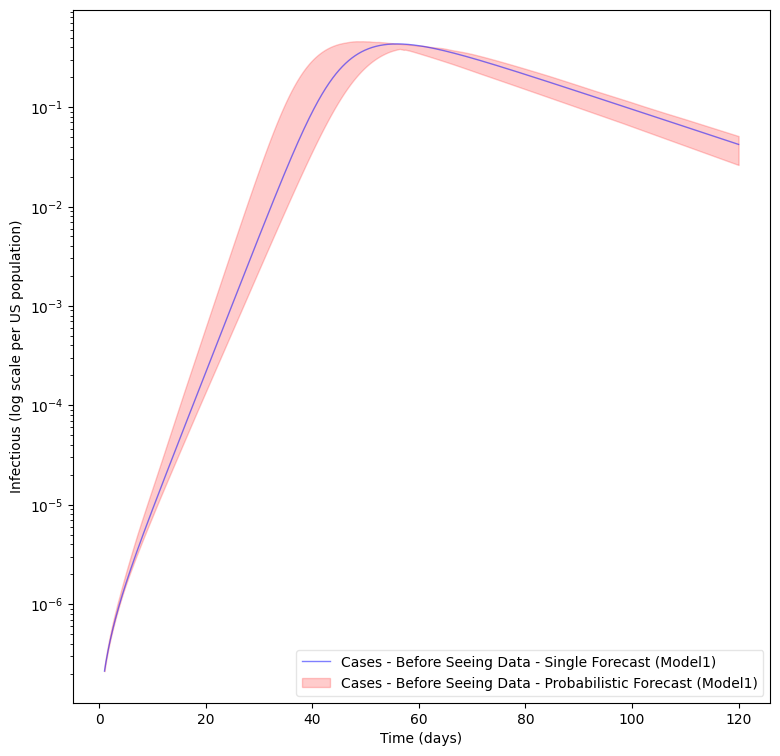

In [88]:
ax = plot_trajectory(single_prior, "Case_obs", full_tspan, ax=setup_ax(ylabel='Infectious (log scale per US population)'), color="blue", marker='', lw=1., label="Cases - Before Seeing Data - Single Forecast (Model1)")
ax = plot_predictive(prior_prediction, "Case_obs", full_tspan, ax=ax, label="Cases - Before Seeing Data - Probabilistic Forecast (Model1)", color="red", alpha=0.2)

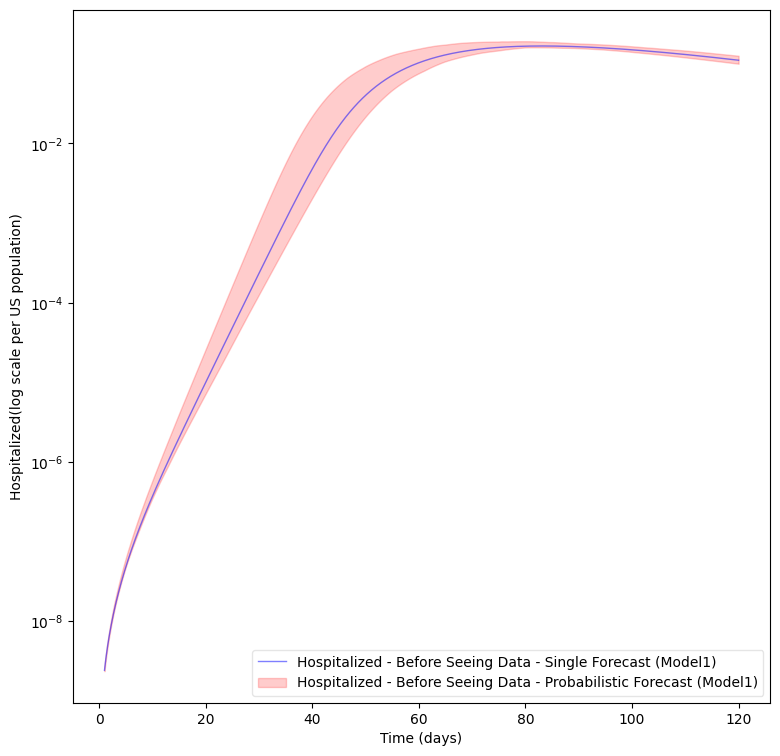

In [89]:
ax = plot_trajectory(single_prior, "Threatened_sol", full_tspan, ax=setup_ax(ylabel='Hospitalized(log scale per US population)'), color="blue", marker='', lw=1., label="Hospitalized - Before Seeing Data - Single Forecast (Model1)")
ax = plot_predictive(prior_prediction, "Threatened_sol", full_tspan, ax=ax, label="Hospitalized - Before Seeing Data - Probabilistic Forecast (Model1)", color="red", alpha=0.2)

### Organize observed data

In [57]:
# data_vals = [i/N for i in [600.0, 623, 661, 675, 715, 750, 773]]
import numpy as np
DATA_PATH = "covid_data"

# cases_data_fname = "us_case_census_and_incident_data.csv"
# cases_data_fname = os.path.join(DATA_PATH, cases_data_fname)
# cases_df = pd.read_csv(cases_data_fname, index_col=0).set_index("date")
# display(cases_df.head())

# hospital_data_fname = "us_hospitalization_census_and_incident_data.csv"
# hospital_data_fname = os.path.join(DATA_PATH, hospital_data_fname)
# hospital_df = pd.read_csv(hospital_data_fname, index_col=0).set_index("date")
# display(hospital_df.head())

# death_data_fname = "us_cumulative_death_data.csv"
# death_data_fname = os.path.join(DATA_PATH, death_data_fname)
# death_df = pd.read_csv(death_data_fname, index_col=0).set_index("date")
# display(death_df.head())

# keep_cols = ["case_census", "cumulative_deaths", "hospital_census"]

# obs_df = pd.merge(cases_df, death_df, how="inner", left_index=True, right_index=True)
# obs_df = pd.merge(obs_df, hospital_df, how="left", left_index=True, right_index=True)


def read_obs_data(filename, keys={'case_census':'Case_obs','cumulative_deaths':'Extinct', 'hospital_census':'Threatened'},start_date=None, end_date=None, population=US_population):
    obs_df = pd.read_csv(filename)
    if start_date and end_date:
        obs_df = obs_df[(obs_df['date'] >= start_date) & (obs_df['date'] < end_date)]
    elif start_date:
        obs_df = obs_df[(obs_df['date'] >= start_date)]
    elif end_date:
        obs_df = obs_df[(obs_df['date'] < end_date)]
    # obs_data = [(float(i+1), dict(I_obs=obs)) for i, obs in enumerate(data_vals)]
    for k in keys:
        obs_df[k] = obs_df[k]/population
    obs_dict = obs_df.to_dict()
    obs_data = []
    for i, idx in enumerate(obs_df.index):
        obs_data.append((i+1, {keys[k]: obs_dict[k][idx] for k in keys if not np.isnan(obs_dict[k][idx])}))
    return obs_data, obs_df.rename(keys, axis=1)
obs_data, obs_df = read_obs_data(os.path.join(DATA_PATH, "US_case_hospital_death.csv"), start_date='2020-03-01', end_date='2020-04-01')


In [41]:
obs_df

,date,Case_obs,Extinct,Threatened
39,2020-03-01,6.929929e-08,6.026025e-09,NaN
40,2020-03-02,1.235335e-07,2.109109e-08,NaN
41,2020-03-03,1.898198e-07,2.410410e-08,NaN
42,2020-03-04,2.922622e-07,3.615615e-08,NaN
43,2020-03-05,5.031731e-07,3.916916e-08,NaN
44,2020-03-06,6.899799e-07,4.519519e-08,NaN
45,2020-03-07,1.199179e-06,5.423422e-08,NaN
46,2020-03-08,1.563753e-06,6.628627e-08,NaN
47,2020-03-09,1.840951e-06,7.231230e-08,NaN
48,2020-03-10,2.323033e-06,8.737736e-08,NaN


In [58]:
obs_data

[(1, {'Case_obs': 6.929928733667458e-08, 'Extinct': 6.026024985797789e-09}),
 (2, {'Case_obs': 1.2353351220885466e-07, 'Extinct': 2.1091087450292262e-08}),
 (3, {'Case_obs': 1.8981978705263035e-07, 'Extinct': 2.4104099943191155e-08}),
 (4, {'Case_obs': 2.922622118111928e-07, 'Extinct': 3.6156149914786736e-08}),
 (5, {'Case_obs': 5.031730863141154e-07, 'Extinct': 3.916916240768563e-08}),
 (6, {'Case_obs': 6.899798608738468e-07, 'Extinct': 4.519518739348342e-08}),
 (7, {'Case_obs': 1.19917897217376e-06, 'Extinct': 5.42342248721801e-08}),
 (8, {'Case_obs': 1.5637534838145262e-06, 'Extinct': 6.628627484377569e-08}),
 (9, {'Case_obs': 1.8409506331612245e-06, 'Extinct': 7.231229982957347e-08}),
 (10, {'Case_obs': 2.323032632025048e-06, 'Extinct': 8.737736229406794e-08}),
 (11, {'Case_obs': 3.3655349545680654e-06, 'Extinct': 1.0244242475856241e-07}),
 (12, {'Case_obs': 4.637026226571399e-06, 'Extinct': 1.3558556218045026e-07}),
 (13, {'Case_obs': 6.456885772282331e-06, 'Extinct': 1.5667664963

## Forecasting - Incorporating Historical Data

### Calibration

In [59]:
# Observed Hospitalization data (a.k.a. "Ailing" in the model)


calibrated_parameters = calibrate_petri(initialized_model1, data=obs_data, verbose=True)



iteration 0: loss = 802.2347030639648
iteration 25: loss = 756.9362626075745
iteration 50: loss = 722.9794068336487
iteration 75: loss = 696.0930614471436
iteration 100: loss = 698.0428366661072
iteration 125: loss = 689.1587109565735
iteration 150: loss = 687.9024124145508
iteration 175: loss = 689.9707055091858
iteration 200: loss = 684.7216477394104
iteration 225: loss = 683.1763591766357
iteration 250: loss = 679.5737915039062
iteration 275: loss = 680.4306306838989
iteration 300: loss = 677.0409970283508
iteration 325: loss = 679.928876876831
iteration 350: loss = 680.2333831787109
iteration 375: loss = 679.1424541473389
iteration 400: loss = 678.1749820709229
iteration 425: loss = 679.5852842330933
iteration 450: loss = 682.9161071777344
iteration 475: loss = 679.3855981826782
iteration 500: loss = 682.013836145401
iteration 525: loss = 680.0140647888184
iteration 550: loss = 679.2389149665833
iteration 575: loss = 679.4329891204834
iteration 600: loss = 679.7477011680603
iterati

## Generated samples from the calibrated parameters

In [18]:
#new_tspan = get_tspan(len(I_obs), 89, 89-len(I_obs))
posterior_prediction = sample(initialized_model1,  inferred_parameters =calibrated_parameters, timepoints=full_tspan, num_samples=100)
posterior_prediction['Case_obs'] = sum([posterior_prediction[f'{v}_sol'] for v in Case_vars])
single_posterior = sample(initialized_model1,  inferred_parameters =calibrated_parameters, timepoints=full_tspan, num_samples=1)
single_posterior['Case_obs'] = sum([single_posterior[f'{v}_sol'] for v in Case_vars])


## Q: "What future outcomes are likely given the data we've seen?"

In [52]:
single_posterior['Case_obs'].shape

torch.Size([1, 1200])

In [73]:
obs_dict = obs_df.to_dict()
obs_df['Extinct']

39    6.026025e-09
40    2.109109e-08
41    2.410410e-08
42    3.615615e-08
43    3.916916e-08
44    4.519519e-08
45    5.423422e-08
46    6.628627e-08
47    7.231230e-08
48    8.737736e-08
49    1.024424e-07
50    1.355856e-07
51    1.566766e-07
52    1.837938e-07
53    2.169369e-07
54    2.922622e-07
55    4.007307e-07
56    5.965765e-07
57    8.225524e-07
58    1.138919e-06
59    1.452272e-06
60    1.816847e-06
61    2.380280e-06
62    3.112442e-06
63    4.115775e-06
64    5.372201e-06
65    6.944994e-06
66    9.093272e-06
67    1.076549e-05
68    1.289569e-05
69    1.614673e-05
Name: Extinct, dtype: float64

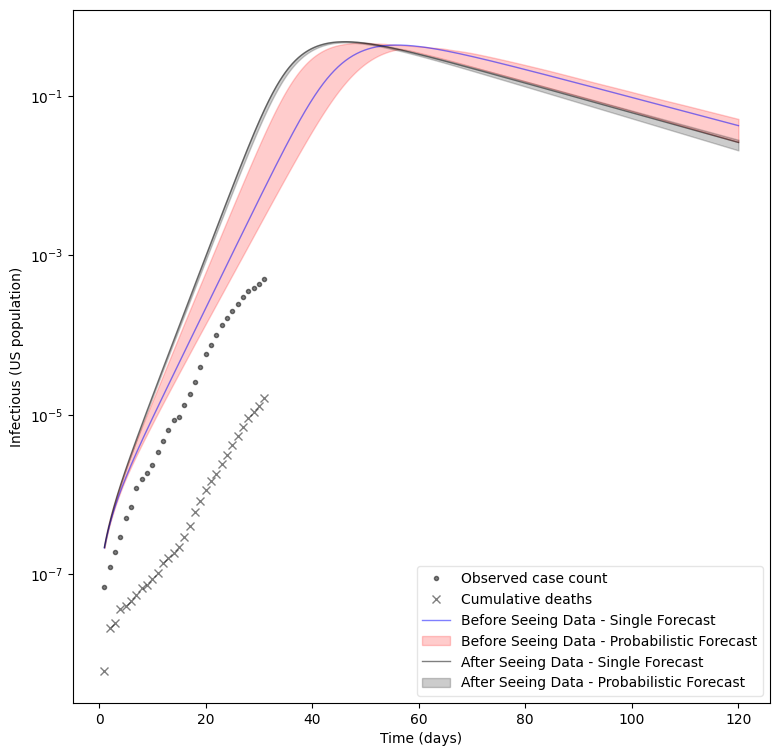

In [85]:
ax = plot_trajectory(obs_df, "Case_obs", get_tspan(1,obs_df.shape[0], obs_df.shape[0]), ax=setup_ax(ylabel='Infectious (log scale)'), label="Observed case count")
ax = plot_trajectory(obs_df, "Extinct", get_tspan(1,obs_df.shape[0], obs_df.shape[0]), ax=ax, label="Cumulative deaths", marker='x')

ax = plot_trajectory(single_prior, "Case_obs", full_tspan, ax=ax, color="blue", marker='', lw=1., label="Infectious  - Before Seeing Data - Single Forecast")
ax = plot_predictive(prior_prediction, "Case_obs", full_tspan, ax=ax, label="Infectious - Before Seeing Data - Probabilistic Forecast", color="red")
ax = plot_trajectory(single_posterior, "Case_obs", full_tspan, ax=ax, marker='', lw=1., label="Infectious - After Seeing Data - Single Forecast")
ax = plot_predictive(posterior_prediction, "Case_obs", full_tspan, ax=ax, label="Infectious - After Seeing Data - Probabilistic Forecast")

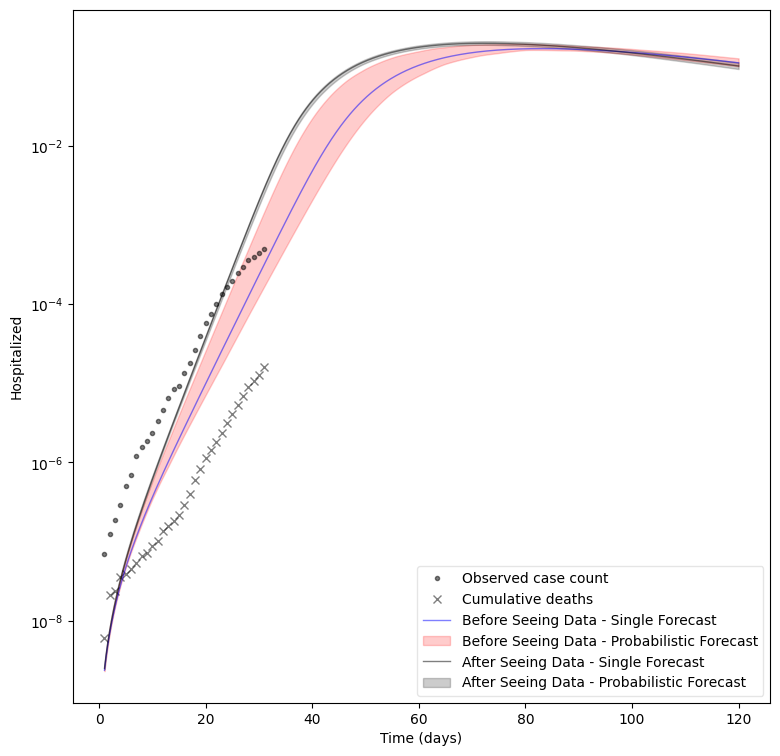

In [86]:
ax = plot_trajectory(obs_df, "Case_obs", get_tspan(1,obs_df.shape[0], obs_df.shape[0]), ax=setup_ax(ylabel='Hospitalized (log scale)'), label="Observed case count")
ax = plot_trajectory(obs_df, "Extinct", get_tspan(1,obs_df.shape[0], obs_df.shape[0]), ax=ax, label='Cumulative deaths', marker='x')

ax = plot_trajectory(single_prior, "Threatened_sol", full_tspan, ax=ax, color="blue", marker='', lw=1., label="Hospitalized - Before Seeing Data - Single Forecast")
ax = plot_predictive(prior_prediction, "Threatened_sol", full_tspan, ax=ax, label="Hospitalized - Before Seeing Data - Probabilistic Forecast", color="red")
ax = plot_trajectory(single_posterior, "Threatened_sol", full_tspan, ax=ax, marker='', lw=1., label="Hospitalized - After Seeing Data - Single Forecast")
ax = plot_predictive(posterior_prediction, "Threatened_sol", full_tspan, ax=ax, label="Hospitalized - After Seeing Data - Probabilistic Forecast")

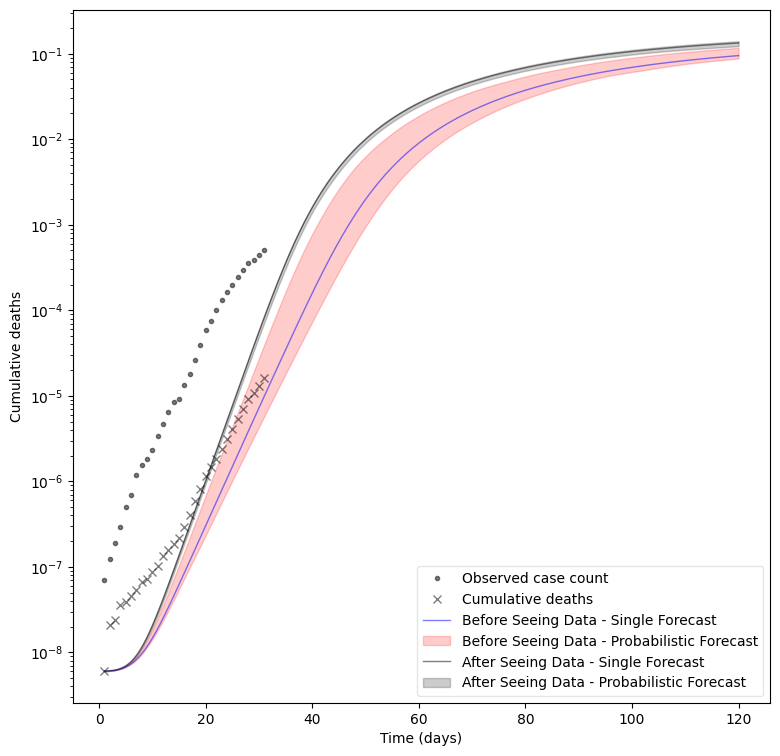

In [87]:
ax = plot_trajectory(obs_df, "Case_obs", get_tspan(1,obs_df.shape[0], obs_df.shape[0]), ax=setup_ax(ylabel='Cumulative deaths (log scale)'), label="Observed case count")
ax = plot_trajectory(obs_df, "Extinct", get_tspan(1,obs_df.shape[0], obs_df.shape[0]), ax=ax, label='Cumulative deaths', marker='x')

ax = plot_trajectory(single_prior, "Extinct_sol", full_tspan, ax=ax, color="blue", marker='', lw=1., label="Before Seeing Data - Single Forecast")
ax = plot_predictive(prior_prediction, "Extinct_sol", full_tspan, ax=ax, label="Before Seeing Data - Probabilistic Forecast", color="red")
ax = plot_trajectory(single_posterior, "Extinct_sol", full_tspan, ax=ax, marker='', lw=1., label="After Seeing Data - Single Forecast")
ax = plot_predictive(posterior_prediction, "Extinct_sol", full_tspan, ax=ax, label="After Seeing Data - Probabilistic Forecast")

In [ ]:
ax = plot_trajectory(plot_I_obs, get_tspan(1,len(I_obs), len(I_obs)), ax=setup_ax())

#ax = plot_trajectory(data, full_tspan, ax=ax)
# ax = plot_trajectory(map_prediction, new_tspan, ax=ax, marker='', lw=1., label="After Seeing Data - Single Forecast")
#ax = plot_predictive(hand_posterior_prediction, new_tspan, ax=ax, label="After Seeing Data - Probabilistic Forecast (manual)", color="blue")
ax = plot_predictive(posterior_prediction, full_tspan, ax=ax, label="After Seeing Data - Probabilistic Forecast (MIRA)")

# Probabilistic Forecasting - Exploring Possible Interventions



## Q: "What would happen if we set the vaccination rate parameter, $\nu$?"


In [10]:
# note that we cannot intervene at a previously existing timepoint, or odeint will complain.
rate_parameter_intervention = [(7.5, "nu", 0.01)]
# intervened_parameter_model = do(plotting_ode_model, rate_parameter_intervention)
intervened_parameter_model = intervene(initialized_petri_net_ode_model, rate_parameter_intervention)
# intervened_parameter_prediction = Predictive(intervened_parameter_model, guide=guide, num_samples=num_samples)(final_observed_state, new_tspan)
intervened_parameter_prediction = sample(intervened_parameter_model, full_tspan, num_samples, calibrated_parameters)
intervened_parameter_prediction ['I_obs'] = intervened_parameter_prediction ['I_sol'] + intervened_parameter_prediction ['I_v_sol']


NameError: name 'initialized_petri_net_ode_model' is not defined

NameError: name 'posterior_prediction' is not defined

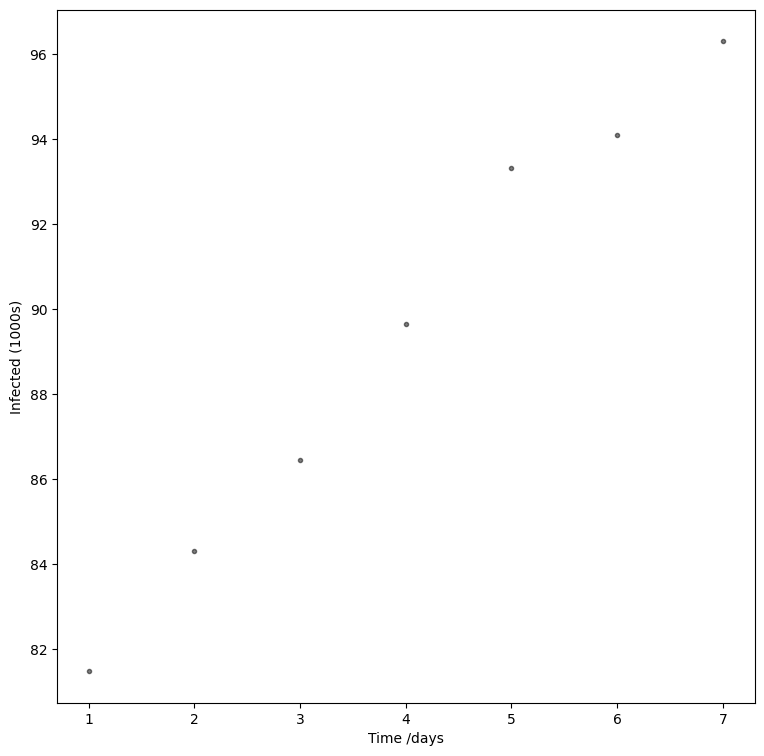

In [11]:

ax = setup_ax()
ax = plot_trajectory(plot_I_obs, observed_tspan, ax=ax)
ax = plot_predictive(posterior_prediction, full_tspan, tmin=7, ax=ax, label="No Intervention")
ax = plot_predictive(intervened_parameter_prediction, full_tspan, ax=ax, color='red', label="Vaccination Rate Parameter Intervention")
ax = plot_intervention_line(7., ax=ax)

## Governor: "We can't change the rate parameter directly. Bring me another policy!"
## Q: "What would happen if we set the vaccination rate to a constant 500 people per day?"

In [ ]:
pyro.set_rng_seed(0)

flux_intervention = constant_intervention_builder("SV_flux", torch.tensor([500.]), full_tspan)
# intervened_flux_model = do(ode_model, flux_intervention)
plotting_intervened_flux_model = intervene(plotting_ode_model, flux_intervention)
# intervened_flux_prediction = Predictive(plotting_intervened_flux, guide=guide, num_samples=num_samples)(final_observed_state, new_tspan)
rate_intervention_prediction = sample(plotting_intervened_flux_model, num_samples, final_observed_state, new_tspan, inferred_parameters=inferred_parameters)

NameError: name 'data' is not defined

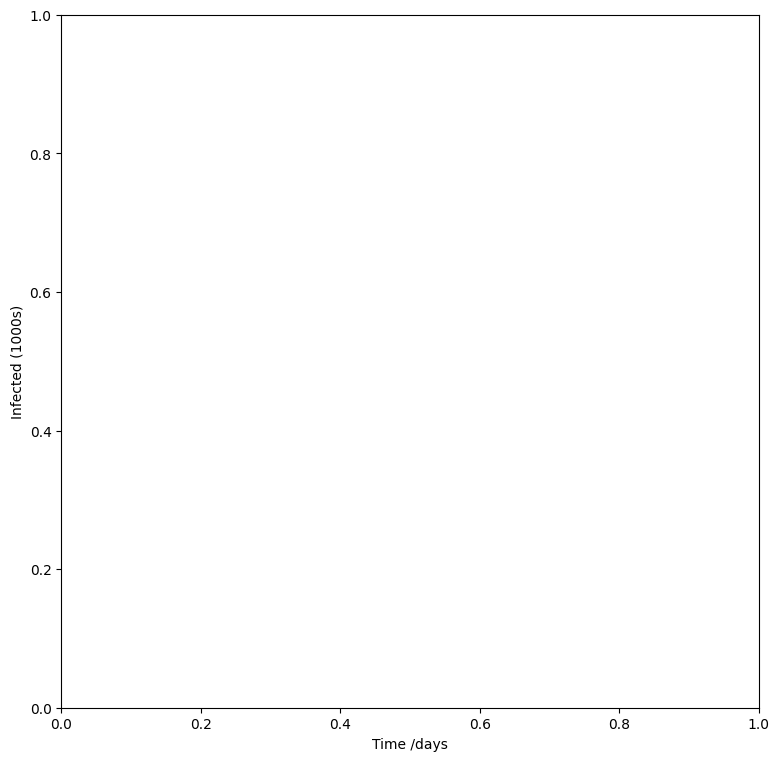

In [12]:

ax = setup_ax()
ax = plot_trajectory(data, observed_tspan, ax=ax)
ax = plot_predictive(posterior_prediction, new_tspan, ax=ax, label="No Intervention")
ax = plot_predictive(rate_intervention_prediction, new_tspan, ax=ax, color='blue', label="Vaccination Rate Intervention")
ax = plot_intervention_line(7., ax=ax)

## Governor: "We have a lot more vaccines than that, but they aren't available yet!"
## Q: "What would happen if we set the vaccination rate to 500 people per day for the first month, then 750, then 1000?"


In [ ]:
pyro.set_rng_seed(0)

def ramping_rate_up_intervention_function(t):
    month = torch.floor(t / 30.).int()
    return torch.tensor([500.0, 750.0, 1000.])[month]

ramping_rate_up_intervention = time_dependent_intervention_builder("SV_flux", ramping_rate_up_intervention_function, new_tspan)
# ramping_rate_up_intervention_model = do(plotting_ode_model, ramping_rate_up_intervention)
plotting_ramping_rate_up_intervention_model = intervene(plotting_ode_model, ramping_rate_up_intervention)
# ramping_rate_up_intervention_prediction = Predictive(plotting_ramping_rate_up_intervention_model, guide=guide, num_samples=num_samples)(final_observed_state, new_tspan)
ramping_intervention_prediction = sample(plotting_ramping_rate_up_intervention_model, num_samples, final_observed_state, new_tspan, inferred_parameters=inferred_parameters)


NameError: name 'data' is not defined

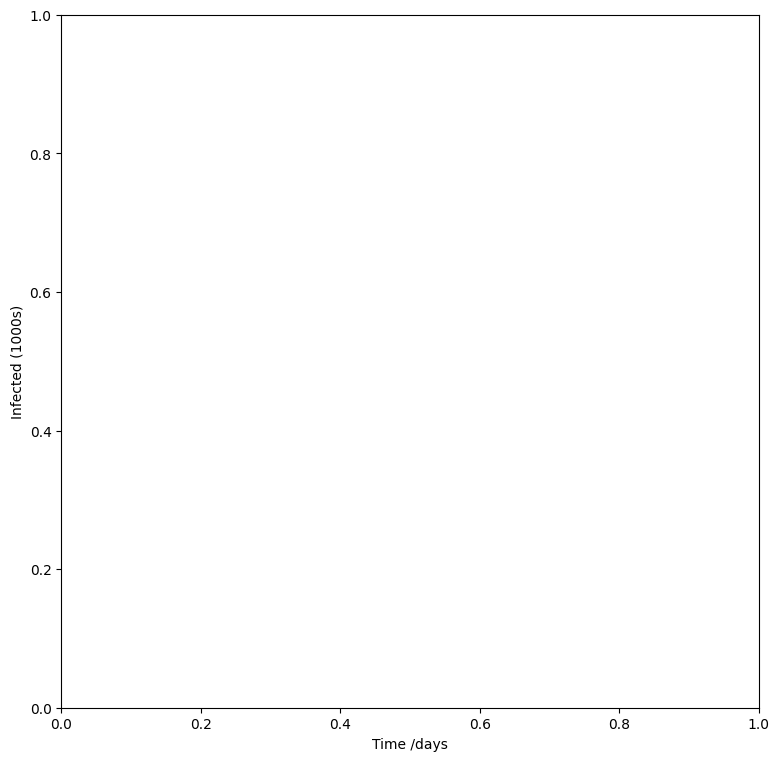

In [13]:

ax = setup_ax()
ax = plot_trajectory(data, observed_tspan, ax=ax)
ax = plot_predictive(posterior_prediction, new_tspan, ax=ax, label="No Intervention")
ax = plot_predictive(ramping_intervention_prediction, new_tspan, ax=ax, color='green', label="Ramping Up Vaccination Rate Intervention")
ax = plot_intervention_line(7., ax=ax)


## Governor: "We can't force people to take a vaccine. Let's run a marketing campaign to encourage vaccination!"
## Q: "What would happen if the marketing campaign convinces 500 **more** people per day to get vaccinated than without it?"


In [ ]:
pyro.set_rng_seed(0)

def vaccination_encouragement_intervention_function(SV_flux):
    return SV_flux + torch.tensor([500.])

vaccination_encouragement_intervention = state_dependent_intervention_builder("SV_flux", vaccination_encouragement_intervention_function, new_tspan)
# plotting_vaccination_encouragement_intervention_model = do(ode_model, vaccination_encouragement_intervention)
plotting_vaccination_encouragement_intervention_model = intervene(plotting_ode_model, vaccination_encouragement_intervention)
# vaccination_encouragement_intervention_prediction = Predictive(vaccination_encouragement_intervention_model, guide=guide, num_samples=num_samples)(final_observed_state, new_tspan)
vaccination_encouragement_intervention_prediction = sample(plotting_vaccination_encouragement_intervention_model, num_samples, final_observed_state, new_tspan, inferred_parameters=inferred_parameters)


NameError: name 'data' is not defined

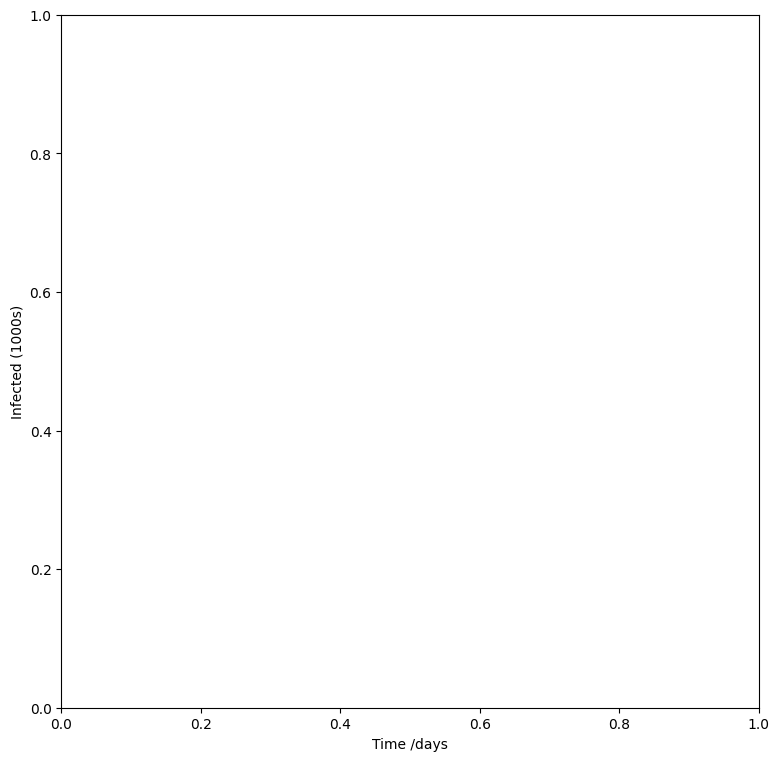

In [14]:

ax = setup_ax()
ax = plot_trajectory(data, observed_tspan, ax=ax)
ax = plot_predictive(posterior_prediction, new_tspan, ax=ax, color='black', label="No Intervention")
ax = plot_predictive(vaccination_encouragement_intervention_prediction, new_tspan, ax=ax, color='purple', label="Vaccination Encouragement Intervention")
ax = plot_intervention_line(7., ax=ax)


In [ ]:

ax = setup_ax()
ax = plot_trajectory(data, observed_tspan, ax=ax)
ax = plot_predictive(posterior_prediction, new_tspan, color='black', ax=ax, label="No Intervention")
ax = plot_predictive(intervened_parameter_prediction, new_tspan, hatch='.', edgecolor="red", linewidth=2.5, facecolor="none", ax=ax, alpha=0.3, label="Vaccination Rate Parameter Intervention")
ax = plot_predictive(rate_intervention_prediction, new_tspan, hatch='/', ax=ax, alpha=0.3, linewidth=2.5, edgecolor='blue', facecolor="none", label="Vaccination Rate Intervention")
ax = plot_predictive(ramping_intervention_prediction, new_tspan, hatch='..', linewidth=3, ax=ax, alpha=0.3, edgecolor='green', facecolor="none", label="Ramping Up Vaccination Rate Intervention")
ax = plot_predictive(vaccination_encouragement_intervention_prediction, new_tspan, hatch="\\", linewidth=2.5, ax=ax, alpha=0.3, edgecolor='black', facecolor="none", label="Vaccination Encouragement Intervention")
ax = plot_intervention_line(7., ax=ax)


## Governor: "Let's only market to young people!"
## Q: "What would happen if the marketing campaign convinces 500 more people age 18-24 per day to get vaccinated than without it?"


In [15]:

pyro.set_rng_seed(0)

stratified_intervention = state_dependent_intervention_builder("SV_flux_18-24", vaccination_encouragement_intervention_function, new_tspan)
# stratified_intervention_model = do(ode_model, stratified_intervention)
stratified_intervention_model = intervene(ode_model, stratified_intervention)


NameError: name 'pyro' is not defined

In [16]:

import sys
ipython = get_ipython()

def hide_traceback(exc_tuple=None, filename=None, tb_offset=None,
                   exception_only=False, running_compiled_code=False):
    etype, value, tb = sys.exc_info()
    value.__cause__ = None  # suppress chained exceptions
    return ipython._showtraceback(etype, value, ipython.InteractiveTB.get_exception_only(etype, value))

ipython.showtraceback = hide_traceback

raise ValueError("The Intervention Variable SV_flux_18-24 is not defined and can not be intervened on. To fix this error, revise the model to include SV_flux_18-24").with_traceback(None) from None

ValueError: The Intervention Variable SV_flux_18-24 is not defined and can not be intervened on. To fix this error, revise the model to include SV_flux_18-24

# Risk-based optimization under uncertainty
## Q: "What is the minimal vaccination policy that results in less than 150 infected individuals after 90 days?"

### Problem Formulation
* **Quantity of interest**: 7-day average of total infections after 90 days
    $$M(\mathbf{u}, \theta) = \frac{1}{7}\sum_{i=0}^6 I(t=90-i;\mathbf{u},\theta)+I_\text{V}(t=90-i;\mathbf{u},\theta)$$

* **Control**: $\mathbf{u}\in \mathcal{U} \subseteq \mathbb{R}^{n_u}$
    * Vaccination rate parameter: $u=\nu$
    * Scheduled intervention changing SV_flux over each month: $\mathbf{u} \in \mathbb{R}^3$
    * Other practical policies as interventions



* **Risk-based optimization under uncertainty problem formulation**
    * Objective Function - Minimize the vaccination rate.
    * Constraint - Risk of infections exceeding the prescribed threshold of 10, $\mathcal{R}( M(\mathbf{u}, \theta))$, is below the acceptable risk threshold, $\mathcal{R}_\text{threshold}$.

\begin{equation} 
\begin{split} 
\mathbf{u}^*= \underset{\mathbf{u}\in\mathcal{U}}{\arg\min}\ & \lVert \mathbf{u} \rVert_1 \\ \text{s.t.}\ & \mathcal{R}( M(\mathbf{u}, \theta)) \le \mathcal{R}_\text{threshold} 
\end{split} 
\end{equation}

## Comparing risk measures

![table_risk.png](figures/table_risk.png)

#### Adavantages of using alpha-superquantile
* Considers magnitude of infections exceeding the threshold:
    * Overcome limitations of hard thresholding
    * Desirable data-informed conservativeness
* Preserves properties of underlying quantities of interest, such as convexity

In [17]:
import os
import time
import pickle

import sys
sys.path.append("../")

import numpy as np
from scipy import stats
from matplotlib import ticker

from pyciemss.ODE.models import SVIIvR
from pyciemss.ODE.interventions import constant_intervention_builder

from pyciemss.risk.risk_measures import alpha_quantile, alpha_superquantile
from pyciemss.risk.ouu import computeRisk
from pyciemss.risk.qoi import nday_rolling_average

# Plotting helpers
def sideaxis(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    return

def sideaxishist(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    # For y-axis
    ax.yaxis.set_major_locator(ticker.NullLocator())
    ax.tick_params(axis='x', labelsize=12)  # change fontsize for x-axis tick labels
    # ax.xaxis.major.formatter._useMathText = True
    return


co = ['#377eb8', '#ff7f00', '#984ea3', '#ffd92f', '#a65628']
rlabel = ['Q_alpha-based OUU', 'barQ_alpha-based OUU']

ModuleNotFoundError: No module named 'pyciemss.ODE'

## Exploring the difference between Quantiles and Super-Quantiles

In [ ]:
torch.manual_seed(1)

POLICY = np.array([100.])
N_SAMPLES = 1000

RISK = computeRisk(model=ode_model,
                 intervention_fun=lambda x: constant_intervention_builder("SV_flux", torch.from_numpy(x), new_tspan),
                 qoi=lambda y: nday_rolling_average(y, contexts=["I_obs"]),
                 risk_measure=alpha_superquantile,
                 num_samples=N_SAMPLES,
                 model_state=final_observed_state,
                 tspan=new_tspan,
                 guide=guide
                )

start_time = time.time()
sq_dataCube = RISK.propagate_uncertainty(POLICY)
end_time = time.time()
forward_time = end_time - start_time
time_per_eval = forward_time / N_SAMPLES
print(f"Forward UQ took {forward_time:.2f} seconds total ({forward_time/N_SAMPLES:.2e} seconds per model evaluation).")
sq_qoi = RISK.qoi(sq_dataCube)
sq_sv = RISK.risk_measure(sq_qoi)

RISK.risk_measure = alpha_quantile
q_sv = RISK(POLICY)

In [ ]:
bins_hist = 50
fig1 = plt.figure()
plt.rc('text', usetex=False)
plt.rc('font', family='serif', size=18.)
cax = plt.gca()
sideaxishist(cax)
cax.hist(sq_qoi, color=co[2], bins=bins_hist, histtype='stepfilled', alpha=0.5, label='total infections')
miny = min(cax.get_ylim())
maxy = max(cax.get_ylim())
cax.vlines(q_sv, miny, maxy, linestyle='--', linewidth=2.5, label='alpha-quantile', color=co[0])
cax.vlines(sq_sv, miny, maxy, linestyle='--', linewidth=2.5, label='alpha-superquantile', color=co[1])
cax.set_xlabel('7-day average infections at 90 days', size=20)
cax.legend(loc='upper right', prop={'size': 20})
plt.show()

## Risk-based optimization under uncertainty with intervention on vaccination rate parameter $\nu$
**NOTE:** This is a demonstration of the interface, optimization is not run to convergence nor are enough samples generated to accurately estimate the risk, so take the results with a grain of salt.

In [ ]:
from pyciemss.risk.ouu import RandomDisplacementBounds, computeRisk, solveOUU
from pyciemss.risk.qoi import nday_rolling_average
from pyciemss.risk.risk_measures import alpha_superquantile, alpha_quantile
import scipy

# Define problem specifics.
RISK_BOUND = 250.
X_MIN = 0.
X_MAX = 0.95

N_SAMPLES = int(5e2)
MAXITER = 10
TOL = 1e-5

RISK_ALPHA = 0.9

# Control action / intervention.
INIT_ITERATE = 0.75
INTERVENTION = lambda x: constant_intervention_builder("nu", x, new_tspan)

# Objective function.
OBJFUN = lambda x: x  # minimize the scalar value itself.

# Define the risk measure.
VAX_RISK = computeRisk(
                        model=noisy_ode_model,
                        intervention_fun=INTERVENTION,
                        qoi=lambda y: nday_rolling_average(y, contexts=["I_obs"]),
                        model_state=final_observed_state,
                        tspan=new_tspan,
                        risk_measure=lambda z: alpha_superquantile(z, alpha=RISK_ALPHA),
                        num_samples=N_SAMPLES,
                        guide=guide,
                        )

# Define problem constraints.
CONSTRAINTS = (
                # risk constraint
                {'type': 'ineq', 'fun': lambda x: RISK_BOUND - VAX_RISK(x)},

                # bounds on control
                # NOTE: perhaps use scipy.optimize.LinearConstraint in the future
                {'type': 'ineq', 'fun': lambda x: x - X_MIN},
                {'type': 'ineq', 'fun': lambda x: X_MAX - x}
               )

In [ ]:
# Go do the dang thing.
print("Performing risk-based optimization under uncertainty ...")
print(f"Estimated wait time {time_per_eval*N_SAMPLES*MAXITER:.0f} seconds.")
sq_result = solveOUU(
                     x0=INIT_ITERATE,
                     objfun=OBJFUN,
                     constraints=CONSTRAINTS,
                     optimizer_algorithm="COBYLA",
                     tol=TOL,
                     options={
                         "disp": False,
                         "maxiter": MAXITER
                             },
                    ).solve()
print(f"Optimizer finished. Optimal Vaccination rate is:\t{sq_result.x[0]:.4}")
est_risk = VAX_RISK(sq_result.x[0])
print(f"Estimated risk was:\t{est_risk:.2f}")

## Assess the effect of the control policy.

In [ ]:
intervened_prediction = VAX_RISK.propagate_uncertainty(POLICY)
qois = VAX_RISK.qoi(intervened_prediction)

In [ ]:

ax = setup_ax()
ax = plot_trajectory(data, observed_tspan, ax=ax)
ax = plot_predictive(posterior_prediction, new_tspan, tmin=7, ax=ax, label="No Intervention")
ax = plot_predictive(intervened_prediction, new_tspan, ax=ax, color='red', label="Vaccination Rate Parameter Intervention")
ax = plot_intervention_line(7., ax=ax)


In [ ]:
bins_hist = 50
fig1 = plt.figure()
# plt.rc('text')
plt.rc('font', family='serif', size=18.)
cax = plt.gca()
sideaxishist(cax)
cax.hist(qois, color=co[2], bins=bins_hist, histtype='stepfilled', alpha=0.5, label='total infections (intervened)', density=True)
cax.hist(VAX_RISK.qoi(posterior_prediction), color=co[4], bins=bins_hist, histtype='stepfilled', alpha=0.5, label='do nothing', density=True)
miny = min(cax.get_ylim())
maxy = max(cax.get_ylim())
cax.vlines(est_risk, miny, maxy, linestyle='--', linewidth=2.5, label='alpha-superquantile', color=co[1])
cax.set_xlabel('7-day average infections at 90 days', size=20)
cax.legend(loc='upper right', prop={'size': 20})
plt.show()

In [ ]:
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""''''''''''''''''''''''''''''''''''''''''''''''/